In [ ]:
# Veri setini buraya yükleyeceğiz. '.csv' ile biten dosyanızı seçin.
from google.colab import files
uploaded = files.upload()

print("\nKütüphaneler yüklendi ve dosya yükleme arayüzü başlatıldı.")
print("Lütfen 'TurkishHeadlines.csv' dosyanızı Colab'e yükleyin.")

Saving TurkishHeadlines.csv to TurkishHeadlines.csv

Kütüphaneler yüklendi ve dosya yükleme arayüzü başlatıldı.
Lütfen 'TurkishHeadlines.csv' dosyanızı Colab'e yükleyin.


In [ ]:
import pandas as pd

# CSV dosyasını oku
df = pd.read_csv("TurkishHeadlines.csv")

# --- Kategorileri Filtrele ve Sayısal Etiketlere Çevir ---
label_map = {
    "Ekonomi": 0,
    "Magazin": 1,
    "Sağlık": 2,
    "Siyaset": 3,
    "Spor": 4
}

# Sadece yukarıdaki 5 kategoriye ait satırları tut
df = df[df["ETIKET"].isin(label_map.keys())]

# Yeni 'label' sütununu oluştur (metin etiketlerini sayısal değerlere dönüştür
df["label"] = df["ETIKET"].map(label_map)

# --- Eksik/Boş Etiketleri Temizle ---
# 'ETIKET' sütunundaki eksik değerleri (NaN) içeren satırları sil
df = df.dropna(subset=["ETIKET"])
# 'ETIKET' sütunundaki sadece boşluklardan oluşan veya boş olan satırları filtrele
df = df[df["ETIKET"].str.strip() != ""]

print("Veri setinin ilk 5 satırı (işlenmiş hali):")
print(df[["HABERLER", "ETIKET", "label"]].head())
print("\nKategori dağılımı (temizlenmiş veri):")
print(df["ETIKET"].value_counts())

Veri setinin ilk 5 satırı (işlenmiş hali):
                                            HABERLER   ETIKET  label
0  TÜİK verilerine göre sanayi ciro endeksi Ağust...  Ekonomi      0
1                  Piyasa güne eksi rezervde başladı  Ekonomi      0
2  Citigroup, Deutsche Bank ve HSBC Libor manipül...  Ekonomi      0
3  Gelişen piyasa yatırımcılarını en fazla 'Fed' ...  Ekonomi      0
4            Bitcoin fiyatında yükseliş hız kesmiyor  Ekonomi      0

Kategori dağılımı (temizlenmiş veri):
ETIKET
Ekonomi    600
Magazin    600
Sağlık     600
Siyaset    600
Spor       600
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Haber metinlerini ve sayısal etiketleri al
texts = df["HABERLER"].tolist()
labels = df["label"].tolist()

# Veriyi %80 eğitim, %20 test olacak şekilde ayır
# 'random_state' aynı bölmeyi her seferinde elde etmemizi sağlar
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

print(f"\nEğitim veri seti boyutu: {len(train_texts)}")
print(f"Test veri seti boyutu: {len(test_texts)}")


Eğitim veri seti boyutu: 2400
Test veri seti boyutu: 600


In [ ]:
import torch
import numpy as np # num_labels için
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

# --- Sınıf Sayısını Belirleme ---
num_labels = len(np.unique(df["label"]))

# --- GPT-2 Tokenizer'ı Tanımlama ---
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# GPT-2'nin tokenizer'ında varsayılan bir pad_token yoktur.
# Sınıflandırma için padding'e ihtiyacımız olduğu için pad_token'ı eos_token'a atıyoruz.
tokenizer.pad_token = tokenizer.eos_token

# --- GPT-2 Modelini Tanımlama ---
# 'num_labels' ile sınıflandırma katmanı eklenir.
# 'pad_token_id'yi ayarlamak, modelin padding token'ını doğru işlemesini sağlar.
model = GPT2ForSequenceClassification.from_pretrained(
    "gpt2",
    num_labels=num_labels,
    pad_token_id=tokenizer.eos_token_id # Modeli tokenizer'ın pad_token_id'si ile bilgilendir
)

# --- Maksimum Giriş Uzunluğunu Ayarlama ---
max_input_length = 64

print(f"Sınıf sayısı: {num_labels}")
print(f"GPT-2 Tokenizer yüklendi. Padding token ID: {tokenizer.pad_token_id}")
print(f"GPT-2 Sınıflandırma Modeli yüklendi. (Başlangıç ağırlıklarıyla)")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sınıf sayısı: 5
GPT-2 Tokenizer yüklendi. Padding token ID: 50256
GPT-2 Sınıflandırma Modeli yüklendi. (Başlangıç ağırlıklarıyla)


In [ ]:
# --- Verilerin Tokenizasyonu ---
# Eğitim metinlerini tokenize et
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_input_length)

# Test metinlerini tokenize et
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_input_length)

print(f"Eğitim metinleri tokenize edildi. İlk encoding örneği (input_ids boyutu): {len(train_encodings['input_ids'][0])}")
print(f"Test metinleri tokenize edildi. İlk encoding örneği (input_ids boyutu): {len(test_encodings['input_ids'][0])}")

Eğitim metinleri tokenize edildi. İlk encoding örneği (input_ids boyutu): 64
Test metinleri tokenize edildi. İlk encoding örneği (input_ids boyutu): 64


In [ ]:
# --- PyTorch Dataset Sınıfı ---
import torch

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

        # GPT-2 için genellikle 'token_type_ids'e gerek yoktur, varsa kaldır
        if 'token_type_ids' in item:
            del item['token_type_ids']

        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Datasetleri oluştur
train_dataset = NewsDataset(train_encodings, train_labels)
test_dataset = NewsDataset(test_encodings, test_labels)

print(f"Eğitim dataseti boyutu: {len(train_dataset)}")
print(f"Test dataseti boyutu: {len(test_dataset)}")

Eğitim dataseti boyutu: 2400
Test dataseti boyutu: 600


In [ ]:
from transformers import TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# --- Eğitim Argümanlarını Tanımlama ---
training_args = TrainingArguments(
    output_dir="./gpt2_results",           # Modelin çıktıları ve checkpoint'lerinin kaydedileceği dizin
    num_train_epochs=3,                    # Eğitim epoch sayısı
    per_device_train_batch_size=16,        # Her cihaz için eğitim batch boyutu
    per_device_eval_batch_size=64,         # Her cihaz için değerlendirme batch boyutu
    eval_strategy="epoch",                 # Değerlendirme stratejisi: her epoch sonunda yap
    save_strategy="epoch",                 # Kaydetme stratejisi: her epoch sonunda kaydet
    logging_dir="./gpt2_logs",             # Logların kaydedileceği dizin
    logging_steps=10,                      # Her 10 adımda bir loglama yap
    load_best_model_at_end=True,           # Eğitim sonunda en iyi modeli yükle
    metric_for_best_model="accuracy",      # En iyi modeli belirlemek için kullanılacak metrik
    report_to="none"                       # Bu satırı ekleyerek WandB entegrasyonunu devre dışı bırakıyoruz.
)

# --- Metrik Hesaplama Fonksiyonu ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

print("Eğitim argümanları ve metrik fonksiyonu tanımlandı.")

Eğitim argümanları ve metrik fonksiyonu tanımlandı.


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from transformers import Trainer

# --- Trainer'ı Oluşturma ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# --- Fine-tuning Başlıyor ---
print("\n--- GPT-2 Modeli Fine-tuning Başlıyor ---")
trainer.train() # Modelin eğitim sürecini başlatır

print("\n--- GPT-2 Modeli Fine-tuning Tamamlandı ---")


--- GPT-2 Modeli Fine-tuning Başlıyor ---


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.574000,0.475733,0.846667,0.845024,0.864774,0.846667
2,0.294500,0.336871,0.901667,0.901637,0.907435,0.901667
3,0.119100,0.313602,0.925000,0.924776,0.926472,0.925000



--- GPT-2 Modeli Fine-tuning Tamamlandı ---


In [ ]:
# --- Eğitilmiş Modeli ve Tokenizer'ı Kaydetme ---
trainer.save_model("./turkish_news_gpt2_model")
tokenizer.save_pretrained("./turkish_news_gpt2_model")

print("\n--- GPT-2 Modeli ve Tokenizer Başarıyla Kaydedildi ---")
print("Model ve tokenizer './turkish_news_gpt2_model' dizininde bulunabilir.")


--- GPT-2 Modeli ve Tokenizer Başarıyla Kaydedildi ---
Model ve tokenizer './turkish_news_gpt2_model' dizininde bulunabilir.


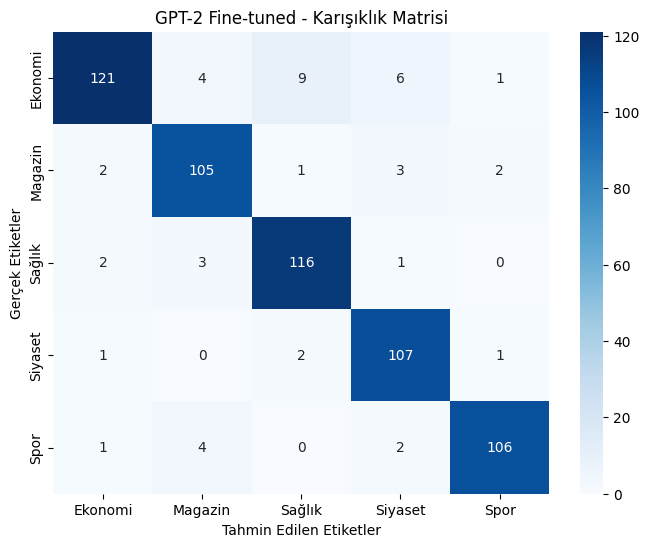


Karışıklık Matrisi görselleştirildi.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Test Verisi Üzerinde Tahminleri Al ---
predictions = trainer.predict(test_dataset)

# Gerçek etiketler
y_true = predictions.label_ids
# Tahmin edilen etiketler
y_pred = predictions.predictions.argmax(-1)

# --- Karışıklık Matrisini Hesapla ---
cm = confusion_matrix(y_true, y_pred)

# --- Label İsimlerini Hazırla (Görselleştirme İçin) ---

labels_display = list(label_map.keys())

# --- Karışıklık Matrisini Görselleştir ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_display, yticklabels=labels_display)
plt.title("GPT-2 Fine-tuned - Karışıklık Matrisi")
plt.xlabel("Tahmin Edilen Etiketler")
plt.ylabel("Gerçek Etiketler")
plt.show()

print("\nKarışıklık Matrisi görselleştirildi.")

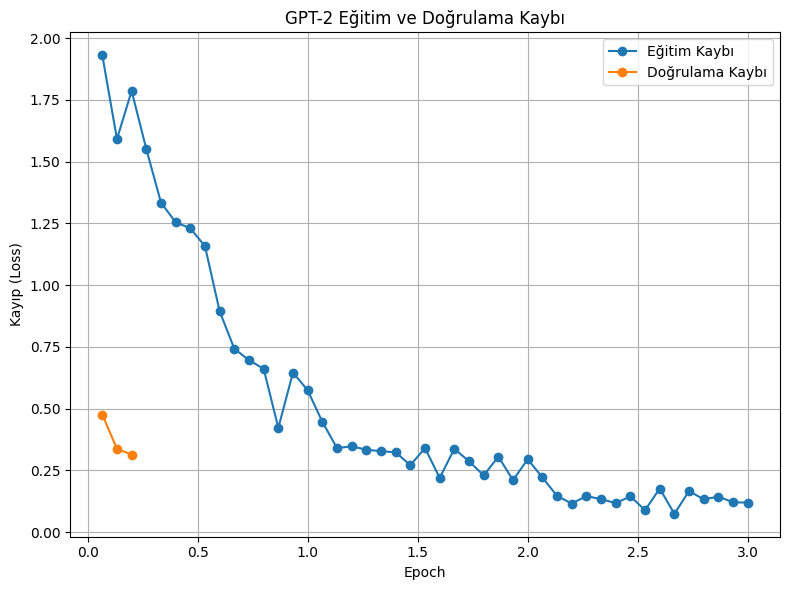


Eğitim ve Doğrulama Kaybı grafiği oluşturuldu.


In [ ]:
import matplotlib.pyplot as plt

# --- Eğitim Geçmişinden Kayıp Değerlerini Çekme ---
train_loss = []
eval_loss = []
epochs = []

for log in trainer.state.log_history:
    if 'loss' in log and 'epoch' in log:
        train_loss.append(log['loss'])
        epochs.append(log['epoch'])
    elif 'eval_loss' in log and 'epoch' in log:
        eval_loss.append(log['eval_loss'])

# --- Kayıp Grafiğini Çizme ---
plt.figure(figsize=(8, 6))
plt.plot(epochs[:len(train_loss)], train_loss, label="Eğitim Kaybı", marker='o')
plt.plot(epochs[:len(eval_loss)], eval_loss, label="Doğrulama Kaybı", marker='o')

plt.xlabel("Epoch")
plt.ylabel("Kayıp (Loss)")
plt.title("GPT-2 Eğitim ve Doğrulama Kaybı")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nEğitim ve Doğrulama Kaybı grafiği oluşturuldu.")

In [ ]:
import torch

# --- Tek Bir Haber Üzerinde Tahmin ---
print("\n--- Tek Bir Haber Üzerinde Fine-tuned GPT-2 ile Tahmin ---")

# Tahmin etmek istediğiniz haber metni
text_to_predict = "Beşiktaş Galatasaray derbisinde kıran kırana mücadele yaşandı.."

# Haber metnini GPT-2 tokenizer ile hazırla
inputs = tokenizer(text_to_predict, return_tensors="pt", truncation=True, padding=True, max_length=max_input_length)

# Eğer GPU (CUDA) varsa, input'ları ve modeli GPU'ya taşı
if torch.cuda.is_available():
    inputs = {k: v.cuda() for k, v in inputs.items()}
    model.to("cuda") # Modeli de GPU'ya taşı (eğitimde GPU kullanıldıysa zaten oradadır)

# Modeli değerlendirme moduna al
model.eval()

# Gradyan hesaplamalarını kapat
with torch.no_grad():
    outputs = model(**inputs) # Modelden tahminleri al

# Tahmin edilen label ID'sini bul
pred_label_id = torch.argmax(outputs.logits, dim=1).item()

# --- Label ID'sini Metin Kategorisine Çevirme ---
label_map_display = {
    0: "Ekonomi",
    1: "Magazin",
    2: "Sağlık",
    3: "Siyaset",
    4: "Spor"
}
predicted_category = label_map_display[pred_label_id]

print(f"Haber: '{text_to_predict}'")
print(f"Tahmin edilen kategori (Fine-tuned GPT-2): {predicted_category}")

print("\n--- İkinci Haber Üzerinde Tahmin ---")
text_to_predict_2 = "Belediye başkanları yeni dönem için planlarını açıkladı."
inputs_2 = tokenizer(text_to_predict_2, return_tensors="pt", truncation=True, padding=True, max_length=max_input_length)
if torch.cuda.is_available():
    inputs_2 = {k: v.cuda() for k, v in inputs_2.items()}

with torch.no_grad():
    outputs_2 = model(**inputs_2)
pred_label_id_2 = torch.argmax(outputs_2.logits, dim=1).item()
predicted_category_2 = label_map_display[pred_label_id_2]

print(f"Haber: '{text_to_predict_2}'")
print(f"Tahmin edilen kategori (Fine-tuned GPT-2): {predicted_category_2}")


--- Tek Bir Haber Üzerinde Fine-tuned GPT-2 ile Tahmin ---
Haber: 'Beşiktaş Galatasaray derbisinde kıran kırana mücadele yaşandı..'
Tahmin edilen kategori (Fine-tuned GPT-2): Spor

--- İkinci Haber Üzerinde Tahmin ---
Haber: 'Belediye başkanları yeni dönem için planlarını açıkladı.'
Tahmin edilen kategori (Fine-tuned GPT-2): Ekonomi
